In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from pjr import *
import string
from timeit import default_timer as timer

pjr.py complete


test latex syntax $a = b^2$

In [2]:
# a useful function for interpolating model to new levels
def getZAMP (fspec, vname, levs):
    """get zonal average field from model on pressure levels"""
    F =  fspec(vname,squeeze=1)            # extract fields, remove dimensions length one
    #lat1 = fspec['lat']
    #lon1 = fspec['lon']
    #lev1 = fspec['lev']

    #Fxav = cdutil.averager(F,axis="x")
    #print "Txav=", Txav.info()

    ps = fspec('PS',squeeze=1)
    hyam = fspec('hyam',squeeze=1)
    hybm = fspec('hybm',squeeze=1)

    start = timer()
    P = cdutil.reconstructPressureFromHybrid (ps,hyam,hybm,1.e5)
    P = P/100.; P.units = "hPa"
    stop1 = timer()
    print  "reconstruct P time = ", stop1-start
    FP1 = cdutil.logLinearInterpolation(F,P,levels=levs)
    stop2 = timer()
    print "interp time", stop2-stop1

    #print "FP1.info", FP1.info()
    FP1xav = cdutil.averager(FP1,axis="x")
    return FP1xav;



In [3]:
# identify the levels that we will interpolate to
levs = findNiceContours(np.array([1000.,10]),50,rmClev=0.) # in hPa
print "levs", levs
nlevs = cdms2.createAxis(levs) # make a cdms vertical grid to remap to
vname = "U"
vnameo = "ua"

dir1 = "/global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/"
f1 = "f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc"
ltit1 = "CAM5-MERRA2"
jname1 = dir1+f1
print "jname1", jname1

dir2 = '/global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/'
f2 = '20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc'
ltit2 = "EAMV1-MERRA2"
jname2 = dir2+f2
print "jname2", jname2

g2 = cdms2.open(jname2)
#print g2
TP2xav = getZAMP (g2, vname, levs)
levsp2 = TP2xav.getAxis(0)
lat2 = TP2xav.getAxis(1)
#print "lat2", lat2
#plotZMf(TP2xav, lat2, levsp2)

print "jname1", jname1
g1 = cdms2.open(jname1);
#varlist = g1.listvariables();
#dims = g1.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'Z' in s) # find vars that contain 'Z'
#print varlist;
#print "levs",levs
TP1xav = getZAMP (g1, vname, levs)

levsp1 = TP1xav.getAxis(0)
lat1 = TP1xav.getAxis(1)
#print "lat1", lat1
#print "levsp1", levsp1

# observations
jname0 = '/global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc'
g0 = cdms2.open(jname0)
ltit0 = "MERRA2"
print "jname0", jname0
g0 = cdms2.open(jname0);
varlist = g0.listvariables();
dims = g0.listdimension();
#print dims;
#print "\n".join(s for s in varlist if 'T' in s) # find vars that contain 'Z'
print varlist;

T0 =  g0('ua',squeeze=1)            # extract fields, remove dimensions length one

TP0 = T0.pressureRegrid(nlevs) # vertical regrid
TM0 = g2('T',squeeze=1) # get a model grid so we can regrid obs
TP0 = TP0.regrid(TM0.getGrid(),regridTool="esmf",regridMethod="linear") # horizontal regrid
# vertical regridding seems to lose the mask so add one back in
list = (TP0 > 0.9*TP0.missing_value) 
TP0.mask = list # make sure the missing vales are masked

# the following line does not work
#TP0 = T.pressureRegrid(nlevs,missing=TP0.missing_value)
#print "TP0.mask", TP0.mask
#print "TP0.info()", TP0.info()

TP0xav = cdutil.averager(TP0,axis="x")
levsp0 = TP0xav.getAxis(0)
lat0 = TP0xav.getAxis(1)
#print "lat0", len(lat0), lat0
#print "TP0xav range", TP0xav.min(), TP0xav.max()
#plotZMf(TP0xav, lat0, levsp0)

DT2xav = TP2xav - TP0xav
DT1xav = TP1xav - TP0xav


levs [  20.   40.   60.   80.  100.  120.  140.  160.  180.  200.  220.  240.
  260.  280.  300.  320.  340.  360.  380.  400.  420.  440.  460.  480.
  500.  520.  540.  560.  580.  600.  620.  640.  660.  680.  700.  720.
  740.  760.  780.  800.  820.  840.  860.  880.  900.  920.  940.  960.
  980. 1000.]
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc
jname2 /global/cscratch1/sd/leebrent/climos/output/20180316.DECKv1b_A1.ne30_oEC.edison/rgr/20180316.DECKv1b_A1.ne30_oEC.edison_ANN_197912_200411_climo.nc


/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3174: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]


reconstruct P time =  1.06379699707


/global/project/projectdirs/acme/software/anaconda_envs/cori/base/envs/e3sm_unified_1.2.4_py2.7_nox/lib/python2.7/site-packages/numpy/ma/core.py:3206: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mout = _mask[indx]


interp time 52.5298650265
jname1 /global/cscratch1/sd/leebrent/climos/output/f.e11.FAMIP.f09_f09_same_setting_LENS/rgr/f.e11.FAMIP.f09_f09_same_setting_LENS_ANN_197912_200511_climo.nc
reconstruct P time =  0.270343065262
interp time 22.2433378696
jname0 /global/project/projectdirs/acme/acme_diags/obs_for_acme_diags/MERRA2_ANN_1980_2016_climo.nc
['va', 'rsds', 'tas', 'rsdscs', 'zg', 'hfss', 'lon_bnds', 'height', 'rlutcs', 'prw', 'hfls', 'time_bnds', 'rlut', 'rlus', 'rlds', 'vas', 'lat_bnds', 'uas', 'ta', 'pr', 'psl', 'rsdt', 'hur', 'rsutcs', 'tauv', 'tauu', 'rsus', 'wap', 'ua', 'rsut']


dlevs [-14. -12. -10.  -8.  -6.  -4.  -2.   2.   4.   6.   8.  10.  12.  14.]


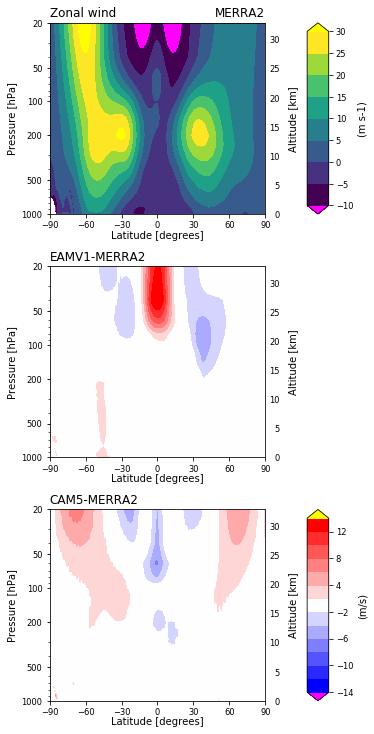

In [4]:
fig = plt.figure(figsize=(5., 10.), facecolor='white')
axest = fig.add_subplot(311)
axesm = fig.add_subplot(312)
axesb = fig.add_subplot(313)
#print "longname", TP0xav.long_name, TP0xav.title
#plotOpt = {'levels':np.arange(170.,330.,10.),'units':'K','title':'Temperature'} #,
#         'ybot':800.,'ytop':500.}
#plotOpt = {}
dlevs = findNiceContours(np.array([DT1xav.min(),DT2xav.min(),DT1xav.max(), DT2xav.max()]),20, rmClev=0., sym=True)
#dlevs = findNiceContours(np.array([DT2xav,DT2xav]),20,rmClev=0.,sym=True)
print "dlevs", dlevs
#print "TP0xav.info", TP0xav.info
#print "plotOpt",plotOpt
plotZMf(TP0xav, TP0xav.getAxis(1), TP0xav.getAxis(0), plotOpt={'ltitle':TP1xav.long_name,'rtitle':ltit0,'colorbar':'right'}, axesa=axest)
cmap = diverge_map()
plotZMf(DT2xav, DT2xav.getAxis(1), DT2xav.getAxis(0), axesa=axesm,fig=fig,plotOpt={'ltitle':ltit2,'clevs':dlevs,'cmap':cmap,'colorbar':'rightnd'})
plotZMf(DT1xav, DT1xav.getAxis(1), DT2xav.getAxis(0), axesa=axesb,fig=fig,plotOpt={'ltitle':ltit1,'clevs':dlevs,'cmap':cmap,'colorbar':'right'})
plt.tight_layout(pad=0, w_pad=0.0, h_pad=1.0)

# show plot
#plt.show()
plt.savefig("Python/test.pdf",type="pdf")